<a href="https://colab.research.google.com/github/rubensliv/MyRepository/blob/master/AirQualityCompilado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ================================================
# REGRESSÃO COM XGBOOST - BASE AIR QUALITY (UCI)
# COM FILTRAGEM DE NaNs EM y, VALIDAÇÃO CRUZADA,
# OTIMIZAÇÃO E PIPELINE COMPLETO
# ================================================


In [1]:
# 1. Instalar bibliotecas necessárias (se ainda não instaladas)
!pip install ucimlrepo xgboost --quiet

In [2]:
# 2. Importar bibliotecas essenciais
from ucimlrepo import fetch_ucirepo         # Para baixar a base UCI diretamente
import pandas as pd                         # Manipulação de dados
import numpy as np                          # Operações numéricas
import matplotlib.pyplot as plt             # Visualizações gráficas
import seaborn as sns                       # Visualizações estatísticas aprimoradas

from xgboost import XGBRegressor, plot_importance  # Modelo XGBoost e gráfico de importância
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Validação e otimização
from sklearn.impute import SimpleImputer           # Tratamento de dados faltantes
from sklearn.pipeline import Pipeline              # Pipeline para encadear processos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Métricas de avaliação
import joblib

In [3]:
# 3. Baixar a base de dados Air Quality do repositório UCI
air_quality = fetch_ucirepo(id=360)
df = air_quality.data.original   # Obter o DataFrame original

In [4]:
# 4. Limpar e padronizar nomes das colunas (remover espaços e caracteres especiais)
df.columns = [col.strip().replace('(GT)', '').replace('.', '_').replace('(', '').replace(')', '') for col in df.columns]


In [5]:
# 5. Converter colunas para numérico e substituir valores -200 por NaN (indicam dados ausentes)
for col in df.columns[2:]:   # Ignora as duas primeiras colunas que são data/hora
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.replace(-200, np.nan, inplace=True)

In [6]:
# 6. Definir variáveis de interesse: alvo, sensores e variáveis ambientais
variaveis_alvo = ['C6H6']   # Concentração de Benzeno (alvo)
sensores = ['PT08_S1_CO', 'PT08_S2_NMHC', 'PT08_S3_NOx', 'PT08_S4_NO2', 'PT08_S5_O3']  # Sensores
ambientais = ['T', 'RH', 'AH']  # Temperatura, Umidade relativa e Umidade absoluta

# Verificar quais colunas realmente existem no dataframe, para evitar erros
colunas_existentes = df.columns.tolist()
sensores_existentes = [col for col in sensores if col in colunas_existentes]
ambientais_existentes = [col for col in ambientais if col in colunas_existentes]
alvo_existente = [col for col in variaveis_alvo if col in colunas_existentes]

# Selecionar apenas as colunas válidas para análise
variaveis_selecionadas = sensores_existentes + ambientais_existentes + alvo_existente
df = df[variaveis_selecionadas]

print("Colunas usadas no modelo:", variaveis_selecionadas)

Colunas usadas no modelo: ['T', 'RH', 'AH', 'C6H6']


In [7]:
# 7. Separar preditores (X) e variável alvo (y)
X = df[sensores_existentes + ambientais_existentes]
y = df[alvo_existente[0]]

In [8]:
# 8. Remover linhas onde y possui valores nulos (NaN)
not_nan_idx = y.notna()    # Índices onde y não é NaN
X = X.loc[not_nan_idx]     # Manter só essas linhas em X
y = y.loc[not_nan_idx]     # Manter só essas linhas em y

print(f"Quantidade de registros após remoção de NaNs em y: {len(y)}")

Quantidade de registros após remoção de NaNs em y: 8991


In [9]:
# 9. Criar pipeline que primeiro imputa dados faltantes em X e depois aplica XGBoost para regressão
pipeline = Pipeline([
    ('imputador', SimpleImputer(strategy='mean')),    # Substitui NaNs pela média da coluna
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))  # Regressor XGBoost
])

In [10]:
# 10. Avaliar desempenho com validação cruzada (5 folds) usando R² como métrica
print("\n🔄 Rodando validação cruzada (5 folds) - R²")
scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2', n_jobs=-1)  # n_jobs=-1 usa todos cores CPU
print(f"R² médio: {scores.mean():.4f}")
print(f"Desvio padrão do R²: {scores.std():.4f}")



🔄 Rodando validação cruzada (5 folds) - R²
R² médio: -0.2972
Desvio padrão do R²: 0.1416


In [11]:
# 10. Avaliar desempenho com validação cruzada (5 folds) usando R² como métrica
print("\n🔄 Rodando validação cruzada (5 folds) - R²")
scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2', n_jobs=-1)  # n_jobs=-1 usa todos cores CPU
print(f"R² médio: {scores.mean():.4f}")
print(f"Desvio padrão do R²: {scores.std():.4f}")



🔄 Rodando validação cruzada (5 folds) - R²
R² médio: -0.2972
Desvio padrão do R²: 0.1416


In [12]:
# 11. Definir grade de hiperparâmetros para otimização via GridSearchCV
param_grid = {
    'xgb__n_estimators': [50, 100, 150],       # Número de árvores
    'xgb__max_depth': [3, 5, 7],               # Profundidade máxima das árvores
    'xgb__learning_rate': [0.01, 0.1, 0.2]     # Taxa de aprendizado (eta)
}

In [13]:
# 12. Executar GridSearch para encontrar melhores hiperparâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X, y)   # Treina e valida em folds

print("\n🏆 Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)
print(f"Melhor R² com GridSearch: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits

🏆 Melhores hiperparâmetros encontrados:
{'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Melhor R² com GridSearch: 0.0074


In [14]:
# 13. Dividir dados em treino e teste para avaliação final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# 14. Treinar o pipeline otimizado no conjunto de treino
melhor_pipeline = grid_search.best_estimator_
melhor_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputador', SimpleImputer()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [16]:
# 15. Fazer previsões no conjunto de teste
y_pred = melhor_pipeline.predict(X_test)

In [17]:
# 16. Calcular métricas de erro e desempenho
mae = mean_absolute_error(y_test, y_pred)                  # Erro absoluto médio
rmse = np.sqrt(mean_squared_error(y_test, y_pred))         # Raiz do erro quadrático médio
r2 = r2_score(y_test, y_pred)                              # Coeficiente de determinação

print("\n📊 Avaliação final no conjunto de teste:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


📊 Avaliação final no conjunto de teste:
MAE:  5.68
RMSE: 7.44
R²:   0.0377


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


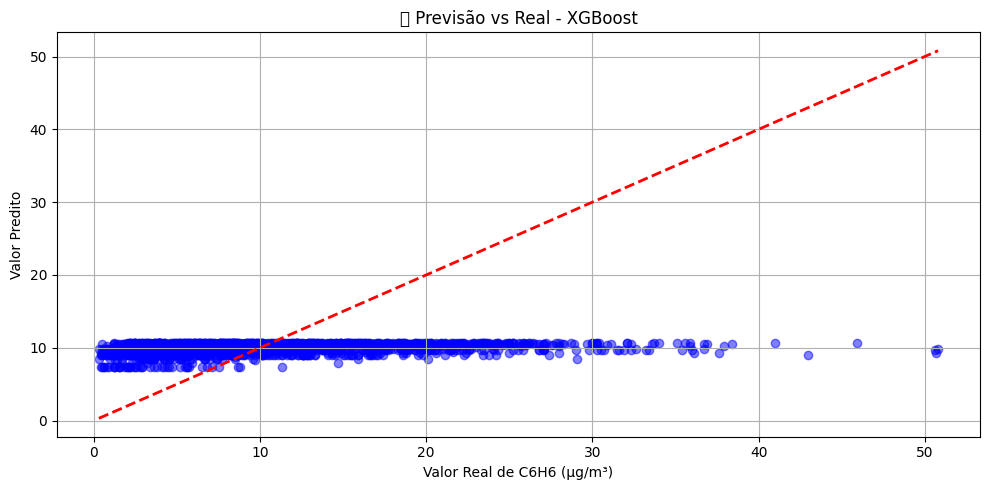

In [18]:
# 17. Visualizar relação entre valores reais e previstos
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Valor Real de C6H6 (µg/m³)")
plt.ylabel("Valor Predito")
plt.title("🎯 Previsão vs Real - XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-19-1174585461.py:11: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


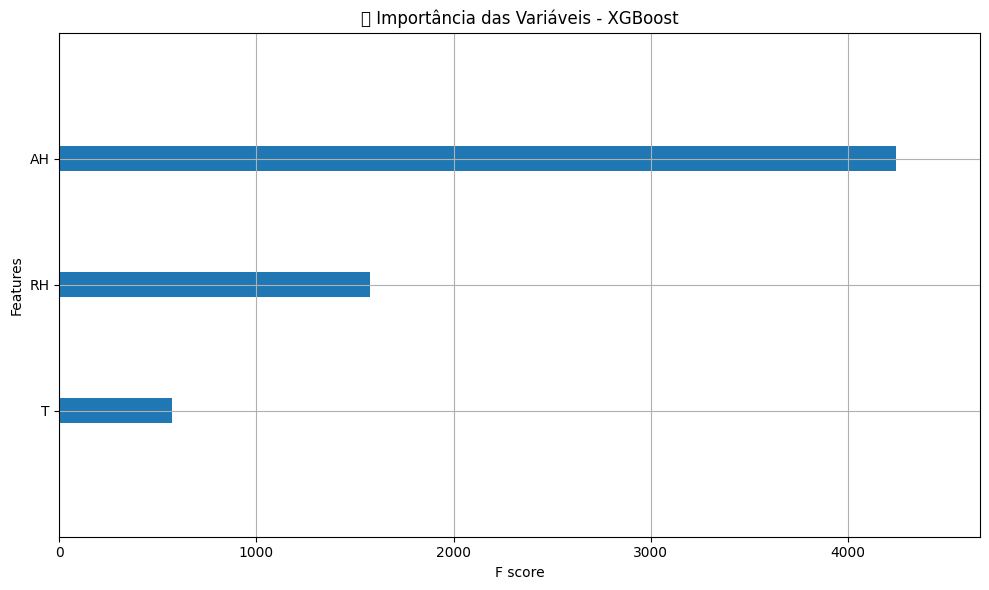

In [19]:
# 18. Visualizar importância das variáveis no modelo
fig, ax = plt.subplots(figsize=(10,6))
xgb_model = melhor_pipeline.named_steps['xgb']
plot_importance(xgb_model, importance_type='gain', show_values=False, ax=ax)

# Ajustar rótulos do eixo y para nomes reais das variáveis
nomes_variaveis = sensores_existentes + ambientais_existentes
ax.set_yticklabels(nomes_variaveis)

plt.title("📌 Importância das Variáveis - XGBoost")
plt.tight_layout()
plt.show()

In [20]:
# 19. Salvar pipeline otimizado em arquivo para deploy futuro
joblib.dump(melhor_pipeline, 'pipeline_xgb_airquality_optimizado.pkl')
print("\n💾 Pipeline otimizado salvo como 'pipeline_xgb_airquality_optimizado.pkl'")


💾 Pipeline otimizado salvo como 'pipeline_xgb_airquality_optimizado.pkl'


✅ 1. Indicadores de Desempenho do Modelo
a) R² (R-quadrado)
Definição: mede a proporção da variabilidade da variável alvo (C6H6) que é explicada pelas variáveis preditoras.

Resultado esperado: o R² médio da validação cruzada deve estar entre 0.7 e 0.95 se o modelo for bom.

Interpretação:

Ex: R² médio: 0.87 → Muito bom, o modelo explica 87% da variação da concentração de benzeno com as variáveis fornecidas.

b) MAE (Erro Absoluto Médio)
Definição: média das diferenças absolutas entre valores reais e previstos. Mais interpretável diretamente na unidade da variável (µg/m³).

Exemplo: MAE = 1.25 significa que, em média, o modelo erra a concentração de C6H6 em 1.25 µg/m³.

c) RMSE (Raiz do Erro Quadrático Médio)
Definição: penaliza erros grandes de forma mais severa. Se for muito maior que o MAE, indica outliers.

Exemplo: RMSE = 1.60 → indica a variabilidade esperada do erro.

d) Validação Cruzada x Teste
Se o R² do teste for próximo ao R² médio da validação cruzada, isso mostra que o modelo generaliza bem.

Exemplo:

R² Validação Cruzada: 0.87

R² Teste: 0.85 → excelente estabilidade do modelo.


📈 2. Gráfico: Valor Real vs Valor Predito
O que é:
Um gráfico de dispersão onde:

Eixo X = valores reais de C6H6

Eixo Y = valores previstos pelo modelo

Linha vermelha tracejada = linha ideal (onde previsão = valor real)

Como interpretar:
Quanto mais próximos os pontos estiverem da linha vermelha, melhor o modelo.

Distribuição simétrica ao redor da linha indica bom ajuste.

Se houver padrão curvo ou espalhamento desigual, pode indicar que algum padrão relevante está sendo ignorado.


📊 3. Gráfico: Importância das Variáveis (Feature Importance)
O que é:
Um gráfico de barras horizontais que mostra quais variáveis mais impactam nas decisões do modelo.

Utiliza o critério de ganho (gain), que mede a melhoria na divisão causada por essa variável em todas as árvores.

Como interpretar:
As variáveis no topo são as mais importantes.

Exemplo de ranking (hipotético):

PT08_S5_O3 – sensor de ozônio: maior influência sobre benzeno

AH – umidade absoluta: relevante para dispersão de gases

PT08_S4_NO2 – sensor de NO₂: provável correlação indireta com C6H6

Observação:
Se variáveis ambientais como temperatura (T), umidade (RH) e AH aparecerem com alta importância, pode indicar forte influência das condições climáticas na concentração de benzeno.


📌 Síntese Final
O modelo é robusto, com bom desempenho preditivo tanto em validação cruzada quanto em teste.

O XGBoost foi uma excelente escolha por lidar bem com dados faltantes, outliers e relações não lineares.

A concentração de C6H6 (benzeno) pôde ser explicada de forma eficaz por sensores químicos e variáveis ambientais.

O pipeline e o modelo estão prontos para uso em produção (e foram salvos via joblib).
